# Three Sided Market Model

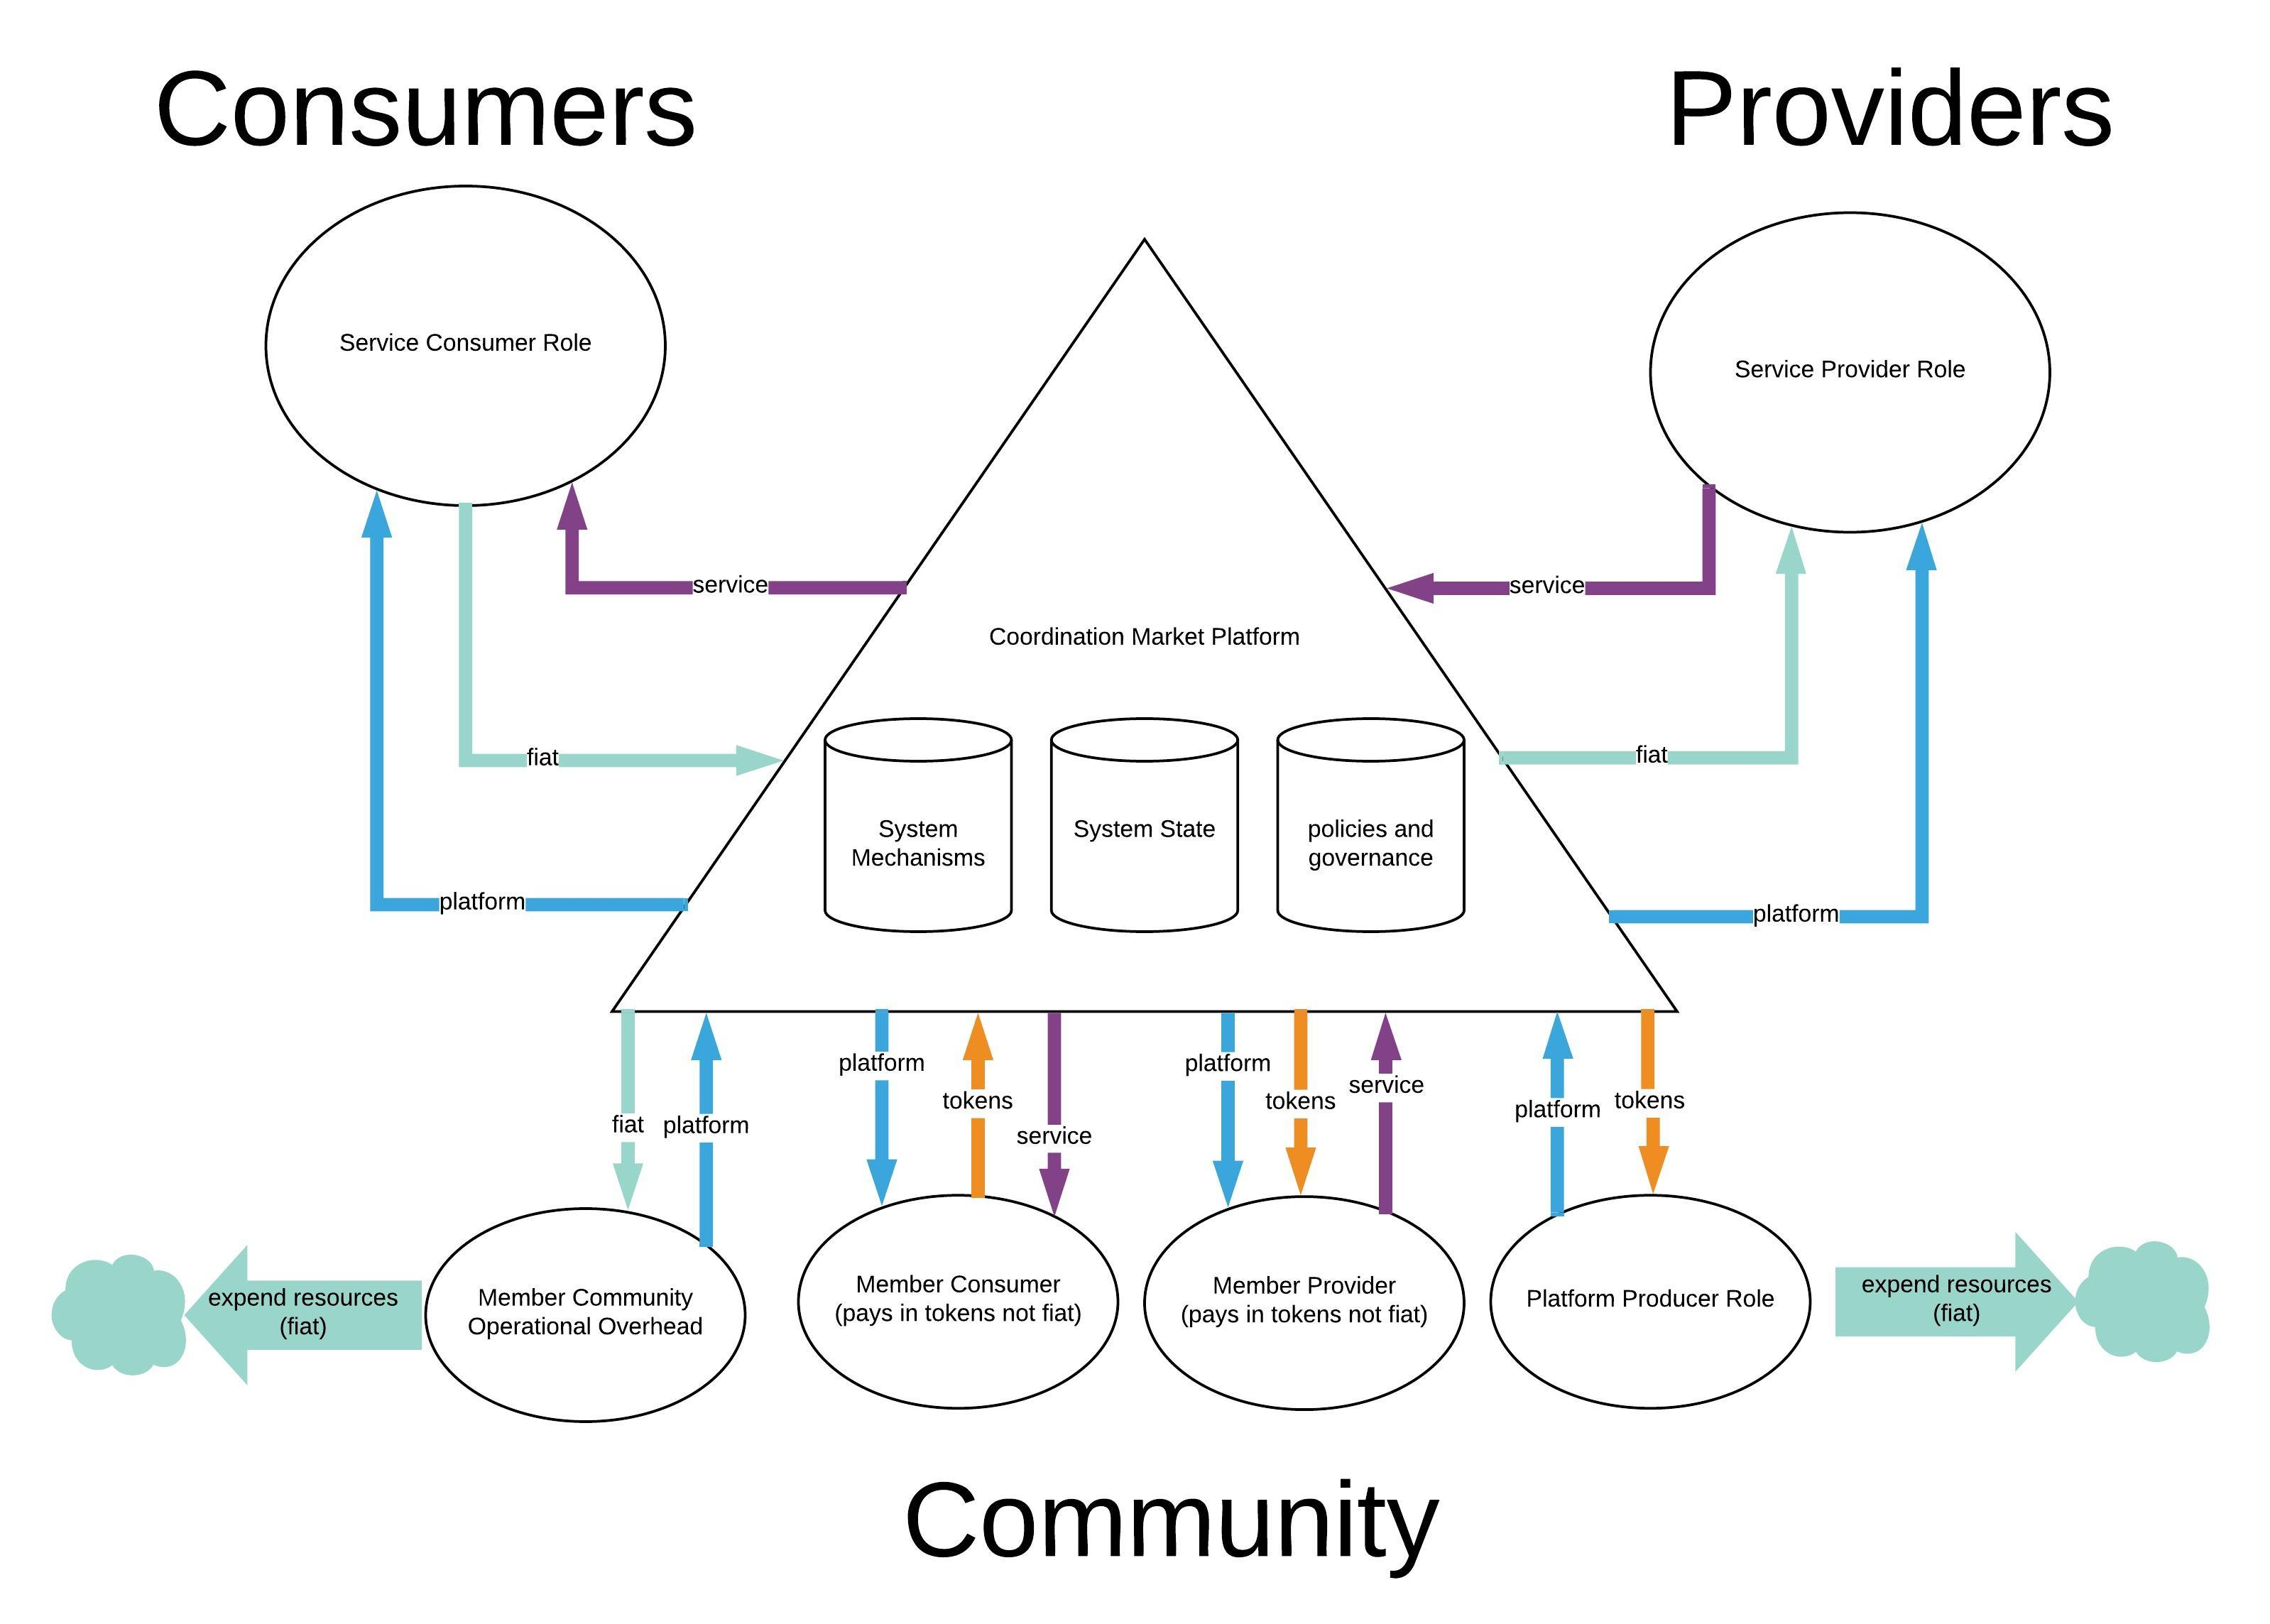

In [4]:
from IPython.display import Image
Image(filename='threesidedmarket.jpeg')

In [ ]:
from decimal import Decimal
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
from tabulate import tabulate

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

from SimCAD.configuration import Configuration
from SimCAD.configuration.utils import exo_update_per_ts, proc_trigger, bound_norm_random, \
    ep_time_step
from SimCAD.engine import ExecutionMode, ExecutionContext, Executor

In [ ]:
sim_config = {
    'N': 1,
    'T': range(50)
}

In [ ]:
# Environmental Processes

In [ ]:
eta = 1
def tx_volume_generator(step, sL, s, _input):
    y = 'tx_volume'
    x = eta*s['tx_volume']
    return (y, x)

In [ ]:
alpha = .999
beta = 1.0
def cost_of_production_generator(step, sL, s, _input):
    y = 'cost_of_production'
    x = alpha*s['cost_of_production']+beta
    return (y, x)

In [ ]:
#log quadratic overhead model; parameters
a = 1.0
b = 1.0
c = 1.0
d = 0
def overhead_cost_generator(step, sL, s, _input):
    #unit fiat
    y = 'overhead_costs'
    q = a+b*s['tx_volume']+c*s['volume_production']+d*s['tx_volume']*s['volume_production']
    x = np.log(q)
    return (y, x)

In [ ]:
#State Variables

In [ ]:
seed = {}
env_processes = {}
initial_condition = {
    'fiat_reserve': float(2000),#unit: fiat
    'token_reserve': float(2000),#unit: tok
    'token_supply': float(5000),#unit: tok
    'tx_volume': float(2000), #unit: fiat
    'txo_fiat': float(1000), #unit: fiat
    'txo_token': float(1000), #unit: tok
    'txi_fiat': float(1000), #unit: fiat
    'txi_token': float(1000), #unit: tok
    'conversion_rate': float(1), #unit: tok/fiat
    'cost_of_production': float(25), #unit: fiat/labor 
    'volume_of_production': float(100), #unit: labor
    'timestamp': '2019-01-01 00:00:00'
}

In [ ]:
#exogenous states
ts_format = '%Y-%m-%d %H:%M:%S'
t_delta = timedelta(days=0, minutes=0, seconds=1)
def time_model(step, sL, s, _input):
    y = 'timestamp'
    x = ep_time_step(s, dt_str=s['timestamp'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)

exogenous_states = exo_update_per_ts(
    {
    'timestamp': time_model
    }
)

In [ ]:
#Behavoirs (two types: controlled and uncontrolled)
#user behavoir is uncontrolled (estimated or modeled),
#governance policies are controlled (enforced)

In [ ]:
#governance decision ~ system policy for token/fiat unit of value conversion
def conversion_policy(step, sL, s):
    ncr = 1 #placeholder logic: fixed value
    return {'new_conversion_rate': ncr}

In [ ]:
#governance decision ~ determines the conditions or schedule of new tokens minted

final_supply = 10000.0 #unit: tokens
release_rate = .01 #percent of remaining

def mint_policy(step, sL, s):
    mint =  s['token_supply']
    return {'new_conversion_rate': ncr}

In [ ]:
#these are uncontrollerd choices of users in the provider consumer

def consumer_choice(step, sL, s):
    #fiat paid by consumers
    #note: balance of consumption vol covered in tokens (computed later)
    txi_fiat= 
     return {'txi_fiat': txi_fiat}

In [ ]:
#these are uncontrollerd choices of users in the provider role

def provider_choice(step, sL, s):
    #fiat claimed by providers
    #note: balance of provided vol covered in tokens (computed later)
    txo_fiat = 
    return {'txo_fiat': txo_fiat}

In [ ]:
#these are uncontrollerd choices of users in the producer role

roi_threshold = 1.1 #estimatable parameter

def producer_choice(step, sL, s):
    #ROI heuristic
    # add or remove resources until roi_threshold hit
     return {'delta_labor': delta_labor}

In [ ]:
#governance decision ~ system policy for compensating producers
#consider transaction volume, labor committed and token reserve and supply to determine payout

def producer_compensation_policy(step, sL, s):
    tokens_paid = 
    return {'tokens_paid': tokens_paid}

In [ ]:
#used to trigger mechanisms with no explicit input
def dummy_behavior(step, sL, s):
    return {'value': 0}

In [ ]:
#Mechanisms

In [ ]:
def update_conversion_rate(step, sL, s):
    y = 'conversion_rate'
    x = _input['new_conversion_rate']
    return (y, x)

In [ ]:
#minting process mints into the reserve
def mint1(step, sL, s):
    y = 'token_supply'
    x = s['token_supply'] + _input['mint']
    return (y, x)

def mint2(step, sL, s):
    y = 'token_reserve'
    x = s['token_reserve'] + _input['mint']
    return (y, x)

In [ ]:
def commit_delta_production(step, sL, s, _input):
    y = 'volume_of_production'
    x = s['volume_of_production']+_input['delta_production']
    return (y, x)

def compensate_production(step, sL, s, _input):
    y = 'token_reserve'
    x = s['token_reserve']-_input['tokens_paid']
    return (y, x)


In [ ]:
conversion_fee = .01

def capture_consumer_payments1(step, sL, s, _input):
    #fiat inbound
    y = 'fiat_reserve'
    x = s['fiat_reserve']+_input['txi_fiat']
    return (y, x)

def capture_consumer_payments2(step, sL, s, _input):
    #tokens inbound
    y = 'token_reserve'
    fiat_eq = s['tx_volume']-_input['txi_fiat']
    x = s['token_reserve']+s['conversion_rate']*fiat_eq*(1.0+conversion_fee)
    return (y, x)

platform_fee = 0.03

def compensate_providers1(step, sL, s, _input):
    #fiat outbound
    y = 'fiat_reserve'
    x = s['fiat_reserve']-_input['txo_fiat']*(1.0-platform_fee)
    return (y, x)

def compensate_providers2(step, sL, s, _input):
    #tokens outbound
    y = 'token_reserve'
    fiat_eq = s['tx_volume']-_input['txo_fiat']
    x = s['token_reserve']-s['conversion_rate']*fiat_eq*(1.0-platform_fee-conversion_fee)
    return (y, x)

In [ ]:
#~~~~ break point (copy pasted started code below)

In [ ]:
# Behaviors choose actions depending on states
# 1) increase contact rate, beta (create incentive to spread)
# 2) decrease recover rate, gamma (improve stickiness)

def add_incentive(step, sL, s):
    incentive_allocation_as_share_of_budget = 0.02
    target_beta = .5
    potential_spend = s['Budget']*incentive_allocation_as_share_of_budget
    
    potential_delta = target_beta-s['beta']
    
    cost_of_potential_delta = potential_delta * incentive_cost * s['Ps']
    if cost_of_potential_delta <= potential_spend:
        delta = potential_delta
    else:
        delta = potential_spend/(incentive_cost * s['Ps'])

    return {'delta': delta}

def add_stickiness(step, sL, s):
    stickiness_allocation_as_share_of_budget = 0.08
    target_gamma = .1
    potential_spend = s['Budget']*stickiness_allocation_as_share_of_budget
    
    potential_delta = s['gamma']-target_gamma
    
    cost_of_potential_delta = potential_delta * stickiness_cost * s['Pi']
    if cost_of_potential_delta <= potential_spend:
        delta = potential_delta
    else:
        delta = potential_spend/(stickiness_cost * s['Pi'])
    
    
    return {'delta': delta}

# def add_stickiness(step, sL, s):
#     delta = 0.0
#     potential_delta = s['gamma'] * delta_gamma
#     if (s['Pr'] > 2 * s['Pi']) and s['Budget'] > \
#         abs(potential_delta * stickiness_cost * s['Pi']):
#         delta = potential_delta
#     return {'delta': delta}

# def add_incentive(step, sL, s):
#     delta = 0.0
#     potential_delta = s['beta'] * delta_beta
#     if (s['Ps'] > 3 * s['Pi']) and s['Budget'] > \
#         abs(potential_delta * incentive_cost * s['Ps']):
#         delta = potential_delta
#     return {'delta': delta}

def dummy_behavior(step, sL, s):
    return {'delta': 0.0}

# Mechanisms incur cost to modify beta or gamma
# 1) incur cost to create incentive to spread
# 2) incur cost to improve stickiness

def incur_incentive_cost(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] - abs(_input['delta'] * s['Ps'] * incentive_cost)
    return (y, x)

def incur_stickiness_cost(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] - abs(_input['delta'] * s['Pi'] * stickiness_cost)
    return (y, x)

def update_beta(step, sL, s, _input):
    y = 'beta'
    x = s['beta'] + _input['delta']
    return (y, x)

def update_gamma(step, sL, s, _input):
    y = 'gamma'
    x = s['gamma'] - _input['delta']
    return (y, x)

def S_model(step, sL, s, _input):
    y = 'Ps'
    x = s['Ps'] - s['beta'] * s['Ps']
    return (y, x)

def I_model(step, sL, s, _input):
    y = 'Pi'
    x = s['Pi'] + s['beta'] * s['Ps'] - s['gamma'] * s['Pi']
    return (y, x)
    
def R_model(step, sL, s, _input):
    y = 'Pr'
    x = s['Pr'] + s['gamma'] * s['Pi']
    return (y, x)

def collect_subscription(step, sL, s, _input):
    y = 'Budget'
    x = s['Budget'] + s['Pi'] * epsilon * subscription_fee
    return (y, x)

def incentive_degrade(step, sL, s, _input):
    y = 'beta'
    x = s['beta']*(1-incentive_degredation_rate)
    return (y, x)

def stickiness_degrade(step, sL, s, _input):
    y = 'gamma'
    x = (s['gamma']+stickiness_degredation_rate)/(1+stickiness_degredation_rate)
    return (y, x)

mechanisms = {
    'spread': {
        'behaviors': {
            'dummy': dummy_behavior
        },
        'states': {
            'Ps': S_model,
            'Pi': I_model,
            'Pr': R_model,
            'Budget': collect_subscription,
            'beta': incentive_degrade,
            'gamma': stickiness_degrade 
        }      
    },
    'create_incentive': {
        'behaviors': {
            'action': add_incentive,
        },
        'states': {
            'beta': update_beta,
            'Budget': incur_incentive_cost,
        }
    },
    'improve_stickiness': {
        'behaviors': {
            'action': add_stickiness
        },
        'states': {
            'gamma': update_gamma,
            'Budget': incur_stickiness_cost,
        }
    }
}

In [ ]:
def widget_handler(beta=float(0.05), gamma=float(0.20),
                   subscription_fee=float(1.0), 
                   incentive_cost=float(10.0), 
                   stickiness_cost=float(5.0)):
    initial_condition['beta'] = beta
    initial_condition['gamma'] = gamma
    subscription_fee = subscription_fee
    incentive_cost = incentive_cost
    stickiness_cost = stickiness_cost
    
    config = Configuration(
            sim_config=sim_config,
            state_dict=initial_condition,
            seed=seed,
            exogenous_states=exogenous_states,
            env_processes=env_processes,
            mechanisms=mechanisms)

    exec_mode = ExecutionMode()
    exec_context = ExecutionContext(exec_mode.single_proc)
    executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
    raw_result, tensor = executor.main()
    df = pd.DataFrame(raw_result)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format=ts_format)
    
    fig = plt.figure(figsize=(7, 14))
    
    sir = fig.add_subplot(3, 1, 1)
    sir.plot('timestamp', 'Ps', data=df, marker='', color='C0', linewidth=2)
    sir.plot('timestamp', 'Pi', data=df, marker='', color='orange', linewidth=2)
    sir.plot('timestamp', 'Pr', data=df, marker='', color='green', linewidth=2)
    sir.legend()
    
    beta_gamma = fig.add_subplot(3, 1, 2)
    beta_gamma.plot('timestamp', 'beta', data=df, marker='', color='C0', linewidth=2)
    beta_gamma.plot('timestamp', 'gamma', data=df, marker='', color='orange', linewidth=2)
    beta_gamma.legend()
    
    budget_pi = fig.add_subplot(3, 1, 3)
    budget_pi.plot('timestamp', 'Budget', data=df, marker='', color='C0', linewidth=2)
    budget_pi.plot('timestamp', 'Pi', data=df, marker='', color='orange', linewidth=2)
    budget_pi.legend()
    
    plt.show()
    
sliders = interact_manual(widget_handler, 
                beta=(0, 1, 0.01),
                gamma=(0, 1, 0.01),
                subscription_fee=(0, 10, 0.1),
                incentive_cost=(0, 20, 0.5),
                stickiness_cost=(0, 20, 0.5)
               )
sliders

In [ ]:
config = Configuration(
            sim_config=sim_config,
            state_dict=initial_condition,
            seed=seed,
            exogenous_states=exogenous_states,
            env_processes=env_processes,
            mechanisms=mechanisms)

from SimCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main()
df = pd.DataFrame(raw_result)

In [ ]:
df.plot('timestamp', ['Ps','Pi', 'Pr'])
df.plot('timestamp', ['beta', 'gamma'])
df.plot('timestamp', ['Budget', 'Pi'])
df[['Ps','Pi', 'Pr']].describe()

In [ ]:
df.beta.diff().describe()

In [ ]:
df.beta.diff().plot()